### Téléchargement des données de réanalyse climatique horaire de ERA5-land du ECMWF (European Centre for Medium-Range Weather Forecasts)


Pour réaliser une requête API, le ECMWF demande une clé, cette clé d'authenfication est gratuite et demande simplement la création d'un compte. Enssuite le code de la clé est consultable depuis le lien : https://cds.climate.copernicus.eu/api-how-to#install-the-cds-api-key

Il faut ensuite Copier/Coller le texte avec la clé personnelle ci dessous (ici la mienne) dans le fichier "USER/.cdsapirc" (à la base du répertoire utilisateur dans l'environnement Windows). 

Le fichier doit être créé à l'aide du Bloc-notes : "Fichier> Enregistrer sous> Type : Tous les fichiers> Nom du fichier : .cdsfapirc" 

### Texte à copier : 
url: https://cds.climate.copernicus.eu/api  
key: 7e6e917c-9390-46c7-96fd-3111ac2d20d9

Le téléchargement des données se fait dans l'ordre des requettes sur le serveur, il y a donc une liste d'attente consultable ici : https://cds.climate.copernicus.eu/requests?tab=all, cela peut prendre 20 secondes ou deux heures donc soyez patient

In [4]:
import cdsapi
import os
import datetime
import xarray as xr
from shapely import wkt
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box
import pandas as pd

In [68]:
pip install cfgrib eccodes

In [5]:
# Chemin et fichier d'enregistrement
folder_out = r"C:\Users\stagiaire\Desktop"
downloaded_file = 'ERA5-Land_hourly_2025.grib'
downloaded_file = os.path.join(folder_out, downloaded_file)

# Emprise spatiale de la zone à extraire [nord, ouest, sud, est]
area = [44.88762, 1.56274, 44.458012, 2.47075]

request = {
    "variable": ["total_precipitation"],#,"2m_temperature","potential_evaporation","total_evaporation"
    "year": "2025",
    "month": [f"{m:02d}" for m in range(1, 13)],
    "day": [f"{d:02d}" for d in range(1, 31)], 
    "time": [f"{h:02d}:00" for h in range(24)],
    "data_format": "grib",
    "download_format": "unarchived",
    "area": area
}

client = cdsapi.Client()

print('Début du téléchargement...')
start = datetime.datetime.now()

client.retrieve('reanalysis-era5-land', request).download(downloaded_file)

print('Téléchargement terminé en', datetime.datetime.now() - start)


2025-05-13 10:16:48,367 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-13 10:16:48,367 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


Début du téléchargement...


2025-05-13 10:16:48,646 INFO Request ID is 078a1dba-4789-4967-ac6a-54e9a3b08c8a
2025-05-13 10:16:48,753 INFO status has been updated to accepted
2025-05-13 10:16:57,407 INFO status has been updated to running
2025-05-13 10:17:21,712 INFO status has been updated to accepted
2025-05-13 10:17:38,891 INFO status has been updated to successful


cb6efd7c2125037c791d1ad290f42601.grib:   0%|          | 0.00/753k [00:00<?, ?B/s]

Téléchargement terminé en 0:00:51.702945


#### 1.Liste des paramètres :
- 2m_temperature (K)
- total_precipitation
- surface_runoff
- runoff
- snow_depth_water_equivalent (m)
- potential_evaporation,
- total_evaporation, 
- evaporation_from_open_water_surfaces_excluding_ocean,
- evaporation_from_bare_soil (m negative)

plus d'info sur : https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview

#### 2.Concaténer les fichier NetCDF: 

In [57]:
# Dossier contenant les fichiers .grib
folder_path = r"C:\Users\stagiaire\Desktop\DATA_ERA"

#lister les fichier .grib
grib_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.grib')]
print(f"{len(grib_files)} fichiers GRIB trouvés :")
for f in grib_files:
    print(f)
#Boucle pour concaténer
datasets = []
for f in grib_files:
    ds = xr.open_dataset(
        f,
        engine='cfgrib',
        backend_kwargs={"indexpath": "", "decode_timedelta": True}
    )
    # Optionnel : tu peux stacker 'time' et 'step' si nécessaire ici
    ds = ds.stack(datetime=('time', 'step'))
    ds = ds.reset_index('datetime')
    ds = ds.assign_coords(datetime=ds['valid_time'].data)
    ds = ds.swap_dims({'datetime': 'valid_time'}).drop_vars(['datetime', 'time', 'step'])

    datasets.append(ds)
ds = xr.concat(datasets, dim='valid_time')
ds

2 fichiers GRIB trouvés :
C:\Users\stagiaire\Desktop\DATA_ERA\ERA5-Land_hourly_2024.grib
C:\Users\stagiaire\Desktop\DATA_ERA\ERA5-Land_hourly_2025.grib


<xarray.Dataset> Size: 2MB
Dimensions:     (latitude: 5, longitude: 10, valid_time: 11856)
Coordinates:
    number      int64 8B 0
    surface     float64 8B 0.0
  * latitude    (latitude) float64 40B 44.86 44.76 44.66 44.56 44.46
  * longitude   (longitude) float64 80B 1.562 1.662 1.762 ... 2.263 2.363 2.463
  * valid_time  (valid_time) datetime64[ns] 95kB 2023-12-31T01:00:00 ... 2025...
Data variables:
    tp          (latitude, longitude, valid_time) float32 2MB nan nan ... nan
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-13T16:19 GRIB to CDM+CF via cfgrib-0.9.1...

#### 3.Conversion des données cumulées
Les variables de la Tab. 3 sont cumulées depuis 00 UTC jusqu’à chaque pas de prévision (max = 24 h, de J 00 UTC à J+1 00 UTC).  
Voir la documentation : \url{https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation}\\[6pt]

Si $\mathrm{tp}_h$ (en m) est la valeur cumulée à l’heure $h$, alors :

\begin{cases}
  \mathrm{tp}_{1}\times1000, 
    & h=1\text{ UTC},\\[4pt]
  (\mathrm{tp}_{h}-\mathrm{tp}_{h-1})\times1000, 
    & 2\le h\le23\,. 
\end{cases}


In [65]:
tp = ds['tp'].transpose('valid_time', 'latitude', 'longitude').values
hours = pd.to_datetime(ds['valid_time'].values).hour
diff = np.zeros_like(tp)

for i in range(tp.shape[0]):
    if hours[i] == 1:
        diff[i] = tp[i]
    else:
        diff[i] = tp[i] - tp[i - 1]

diff = np.where(diff < 0, 0, diff)
ds['tp_diff'] = (('valid_time', 'latitude', 'longitude'), diff.astype(tp.dtype))

#### 4.Intersection entre le bassin versant et chacune des mailles ERA5-Land

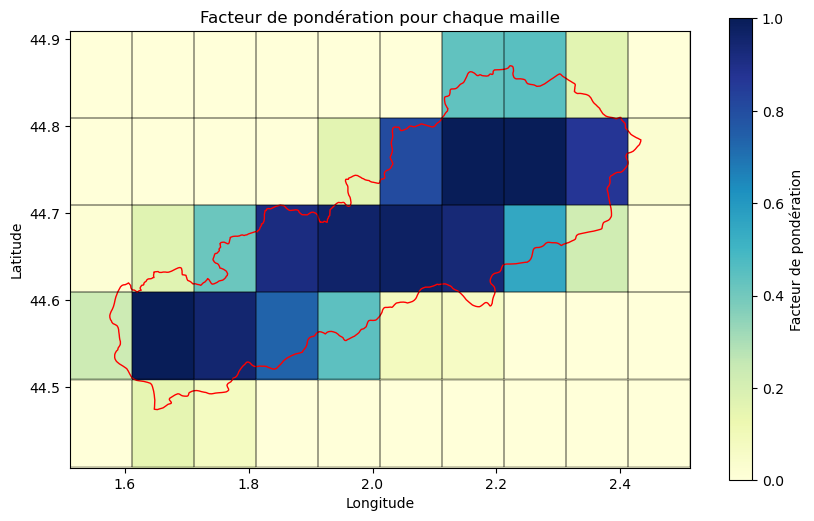

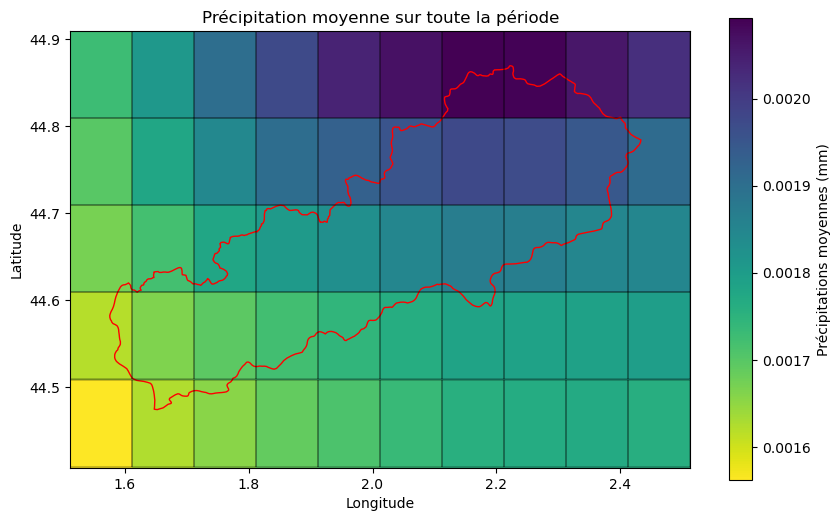

In [66]:
BV_CELE = "MultiPolygon (((2.22672097 44.85934102, 2.22700813 44.85845818, 2.22806883 44.85616228, 2.22917476 44.8551401, 2.23173228 44.85411518, 2.23447032 44.85412292, 2.23894966 44.85416514, 2.24240107 44.85382296, 2.24472541 44.85344778, 2.24660269 44.85269399, 2.24774636 44.85137282, 2.24820976 44.8505725, 2.24853369 44.85001527, 2.25040308 44.84864313, 2.2522115 44.84824368, 2.25511512 44.84775847, 2.25868047 44.84741586, 2.26130864 44.84703231, 2.26292742 44.84644707, 2.26328538 44.84631438, 2.26535339 44.84554701, 2.27063421 44.84584505, 2.27793622 44.84841308, 2.27794926 44.84841927, 2.28817737 44.85352935, 2.29092021 44.85470324, 2.29370936 44.85609451, 2.29665797 44.85754451, 2.2983568 44.85842517, 2.29965605 44.85892438, 2.30158254 44.8596608, 2.30214605 44.8598135, 2.30379368 44.85938843, 2.30412417 44.85912679, 2.30502867 44.85840984, 2.30724905 44.85700387, 2.30888513 44.85623557, 2.31155429 44.8551295, 2.31442195 44.85371632, 2.31689823 44.85252765, 2.32034362 44.85111855, 2.32348175 44.84968354, 2.32558383 44.84893876, 2.32699202 44.84807433, 2.32708765 44.84792492, 2.32736157 44.84713869, 2.32717344 44.84617517, 2.32680144 44.8447881, 2.32663787 44.84422544, 2.32670465 44.84342476, 2.32637317 44.84239424, 2.32624164 44.84099587, 2.32620262 44.840595, 2.32588416 44.83972318, 2.3267982 44.83903389, 2.32761079 44.83857231, 2.32846972 44.83809013, 2.33068572 44.83734835, 2.33097393 44.83730715, 2.33426877 44.83741036, 2.33608058 44.8373558, 2.33960859 44.83694567, 2.34068464 44.83673647, 2.34296275 44.83647774, 2.34522633 44.83612932, 2.34656011 44.83573764, 2.34832975 44.83517691, 2.34947085 44.83468217, 2.35055392 44.83382882, 2.35218427 44.83263739, 2.3530775 44.83160061, 2.35398655 44.83032269, 2.35506059 44.82889635, 2.35630979 44.82745967, 2.35718266 44.82665266, 2.35863607 44.82560852, 2.35985931 44.82486119, 2.36108685 44.82406748, 2.36221442 44.82322431, 2.36260378 44.8229326, 2.36479808 44.82144409, 2.36586193 44.82078741, 2.36684467 44.82010808, 2.36743042 44.81895071, 2.36819587 44.81814673, 2.36972521 44.81646045, 2.37189392 44.81410621, 2.37455087 44.81259882, 2.37656663 44.8114471, 2.37980717 44.81057724, 2.3830045 44.81008445, 2.38721512 44.80965708, 2.38997509 44.80908494, 2.39223703 44.80848206, 2.39424613 44.8084048, 2.39927789 44.80982624, 2.40103089 44.8098201, 2.40137254 44.80858128, 2.40273656 44.80647216, 2.40505499 44.80491683, 2.40662127 44.8038648, 2.40784427 44.80266251, 2.40822582 44.80107947, 2.40845187 44.7978581, 2.40898659 44.797257, 2.41067114 44.79610901, 2.41495713 44.7924789, 2.41699773 44.79054844, 2.41934891 44.78933802, 2.4259156 44.78659817, 2.42878353 44.78572924, 2.43160171 44.78458309, 2.43325481 44.78415301, 2.43300104 44.78212426, 2.43102309 44.77859561, 2.42824513 44.77669982, 2.42694862 44.77563435, 2.42438888 44.7734106, 2.42101482 44.77111424, 2.41734591 44.76980826, 2.41483979 44.76929068, 2.41180705 44.76866108, 2.41059363 44.76770459, 2.40967951 44.76662115, 2.40927084 44.76488614, 2.40977504 44.7632979, 2.41065584 44.76215559, 2.41089119 44.76185249, 2.41220727 44.75961246, 2.41250876 44.75795015, 2.41240599 44.75679406, 2.41199952 44.75563715, 2.41108374 44.7542652, 2.40925506 44.75253319, 2.40588076 44.74968202, 2.40350001 44.74793067, 2.40102633 44.74697482, 2.40001104 44.746759, 2.39584963 44.74676126, 2.39382062 44.74640165, 2.39260127 44.74596844, 2.39036796 44.7451019, 2.38712483 44.74346911, 2.38468352 44.74262418, 2.38360827 44.74140563, 2.38291221 44.74061866, 2.38315706 44.73946962, 2.38346191 44.73744573, 2.38346014 44.73527872, 2.38325549 44.73426898, 2.38264578 44.73289566, 2.38223895 44.73210137, 2.38122483 44.73108988, 2.38010672 44.73015159, 2.3792937 44.72928428, 2.37888812 44.72812829, 2.37878614 44.72704431, 2.38054286 44.72203886, 2.38116598 44.71855886, 2.38217228 44.71546101, 2.38289078 44.71220355, 2.38379599 44.70942722, 2.38501228 44.70554717, 2.38561622 44.70214756, 2.385838 44.69962191, 2.38577045 44.69665127, 2.38488656 44.6951998, 2.38373419 44.69394525, 2.38298661 44.69302746, 2.3812234 44.69191635, 2.37945914 44.69124108, 2.37674579 44.69042084, 2.37450785 44.68974462, 2.37308174 44.68906811, 2.37247315 44.6882955, 2.37165762 44.68684597, 2.37097734 44.68442988, 2.37077468 44.6836561, 2.37034057 44.68224561, 2.36995767 44.6819469, 2.3683571 44.68135488, 2.36687948 44.68106573, 2.36343322 44.6803896, 2.35694247 44.67922141, 2.3501979 44.67839083, 2.33807984 44.67658418, 2.33231931 44.67566904, 2.32947176 44.67423969, 2.32871384 44.67291351, 2.32802682 44.671, 2.32733679 44.66996851, 2.3253429 44.66903785, 2.32231378 44.66810495, 2.31668762 44.6661205, 2.31468083 44.66571411, 2.3121659 44.66516126, 2.30746258 44.66389783, 2.30632953 44.66330297, 2.30509686 44.66276371, 2.30461169 44.66285733, 2.3023399 44.66401375, 2.29989048 44.66508661, 2.29723337 44.66572039, 2.29340702 44.66591781, 2.28979304 44.66592455, 2.28604012 44.66629588, 2.28298918 44.66636036, 2.27978777 44.66531186, 2.27722852 44.66334657, 2.275158 44.66216665, 2.27479441 44.66195934, 2.27184296 44.66108488, 2.26883206 44.66049779, 2.26431194 44.66038259, 2.26141537 44.659681, 2.26036705 44.65877559, 2.25959606 44.65779102, 2.25899172 44.65637381, 2.25885245 44.65583275, 2.25823084 44.65339132, 2.25816184 44.6531821, 2.25707528 44.6498882, 2.25575504 44.64756577, 2.25338549 44.64532084, 2.24974676 44.64354678, 2.24643607 44.64342561, 2.23976216 44.64271307, 2.23144211 44.64176878, 2.22460166 44.64152501, 2.22211803 44.64144414, 2.21996618 44.64144187, 2.2181462 44.64147804, 2.21570588 44.64139501, 2.21340755 44.64106273, 2.21045993 44.64004033, 2.20851342 44.63737865, 2.20746472 44.63469741, 2.20540754 44.63259917, 2.20328814 44.63184135, 2.20039356 44.63123502, 2.1993521 44.63108535, 2.19672856 44.63060703, 2.19358587 44.62889771, 2.19200498 44.62702241, 2.19045774 44.62446194, 2.18994405 44.62229128, 2.19030814 44.62044019, 2.19151711 44.61878186, 2.19394611 44.61725289, 2.1960882 44.61560603, 2.19721897 44.61395888, 2.19782902 44.61111377, 2.19761828 44.60828205, 2.19685532 44.60653049, 2.19578657 44.60481151, 2.19469921 44.60249797, 2.19392877 44.6003569, 2.19347837 44.59827911, 2.19323074 44.59643239, 2.19152715 44.5938491, 2.1905148 44.59332331, 2.18953693 44.59339619, 2.18760838 44.59524513, 2.18592193 44.59657405, 2.18428498 44.59717352, 2.18258333 44.59716393, 2.18092796 44.59659284, 2.17742671 44.59452607, 2.17464917 44.59310526, 2.17277076 44.59244202, 2.17019978 44.59242166, 2.16712584 44.59278582, 2.16363787 44.59365928, 2.16122582 44.59444264, 2.15654918 44.59717892, 2.15121976 44.60048884, 2.14911915 44.60244502, 2.14825119 44.60322456, 2.1465125 44.60472589, 2.14334439 44.60705723, 2.13944831 44.60959532, 2.13689789 44.61087146, 2.13326371 44.61184467, 2.12977603 44.61334765, 2.12736496 44.6154471, 2.12513931 44.61652988, 2.12328594 44.61681583, 2.12145062 44.61765201, 2.11708963 44.61874279, 2.11404521 44.61848731, 2.11072632 44.61833113, 2.10835578 44.61804906, 2.10700113 44.61770003, 2.10593046 44.61811097, 2.10401888 44.6181327, 2.10091461 44.61704007, 2.09804451 44.61620133, 2.09448316 44.61544652, 2.09202144 44.61494648, 2.08648516 44.61489485, 2.08552013 44.61488647, 2.08245492 44.61420555, 2.07864962 44.61293138, 2.07585088 44.61051473, 2.07413026 44.60800786, 2.07274538 44.60621479, 2.07100402 44.60327301, 2.07006223 44.60206004, 2.0697913 44.60171215, 2.06739592 44.59988359, 2.0645256 44.59848449, 2.0604248 44.59748098, 2.0564138 44.59671762, 2.05328391 44.59739787, 2.0499048 44.59773221, 2.04472405 44.59758461, 2.04365673 44.59734066, 2.03931903 44.59676849, 2.03818847 44.59649134, 2.03562923 44.59479662, 2.03259559 44.59232775, 2.03132716 44.59170601, 2.02897656 44.5920065, 2.02408894 44.59163207, 2.02076528 44.59162256, 2.01910705 44.59136328, 2.01768821 44.59034323, 2.01627473 44.58864623, 2.01515616 44.58582183, 2.01305586 44.58325212, 2.01148206 44.58141034, 2.00770571 44.5785553, 2.00614522 44.57744298, 2.00448898 44.57693002, 2.0010495 44.57666609, 1.99630579 44.57682046, 1.99393558 44.5763896, 1.99299317 44.57562419, 1.99228677 44.57469156, 1.98971014 44.56943275, 1.98582826 44.56716393, 1.98183931 44.56637627, 1.97991004 44.56468951, 1.97872684 44.56332146, 1.97786744 44.56248613, 1.97359852 44.56004458, 1.97299621 44.55980869, 1.97105383 44.55865958, 1.96768302 44.55757054, 1.96499327 44.55658572, 1.96174347 44.55532382, 1.95948398 44.55467416, 1.95777688 44.55374612, 1.9567709 44.55355923, 1.95499911 44.55389104, 1.95335549 44.55528658, 1.95243649 44.55670525, 1.95043659 44.55770901, 1.94790996 44.55859855, 1.94608939 44.55948952, 1.94432057 44.56080515, 1.94082467 44.56258954, 1.93659483 44.56358085, 1.93337147 44.56408526, 1.92976842 44.56387413, 1.92678909 44.56312119, 1.92370613 44.56118595, 1.92115821 44.56234064, 1.91703657 44.56346762, 1.91463369 44.5637026, 1.91349287 44.56361681, 1.91098416 44.56279106, 1.90916338 44.56172272, 1.90803196 44.56041284, 1.90712103 44.55967463, 1.90632911 44.55901828, 1.90496015 44.55844209, 1.90313477 44.55818967, 1.90153645 44.55802055, 1.89834623 44.55686415, 1.8962998 44.55522491, 1.8951741 44.5534255, 1.89461748 44.55146353, 1.8941781 44.54925783, 1.89305149 44.54705039, 1.89168871 44.54538498, 1.88933928 44.54333533, 1.88794966 44.54198813, 1.88655424 44.54029574, 1.88518765 44.53986356, 1.88128121 44.53908289, 1.87551811 44.53810676, 1.86909623 44.53616828, 1.86173577 44.53335781, 1.85643415 44.53040544, 1.85275918 44.52712206, 1.84900266 44.52448938, 1.84496665 44.52157815, 1.84111198 44.52068501, 1.83813421 44.52111971, 1.8377445 44.52121685, 1.8349228 44.5219077, 1.8319664 44.52267616, 1.82888883 44.52377473, 1.82570548 44.52413911, 1.82166627 44.52406561, 1.81795707 44.52428408, 1.81498667 44.52388464, 1.81202976 44.52358719, 1.80845632 44.52407182, 1.80530485 44.52546405, 1.8025334 44.52762153, 1.80020875 44.52867145, 1.79880772 44.5289263, 1.79653407 44.5285545, 1.79412699 44.52649119, 1.79021399 44.52394225, 1.78761174 44.52155739, 1.78415525 44.5179029, 1.78265304 44.51514842, 1.78072668 44.51278124, 1.7784299 44.51133739, 1.77460256 44.51018858, 1.77370283 44.50858693, 1.77142367 44.50628475, 1.76665396 44.50426634, 1.76489528 44.50235929, 1.76583596 44.50017884, 1.76743201 44.49809864, 1.76773308 44.49665772, 1.76602298 44.49551649, 1.76370018 44.4946121, 1.76095 44.49426282, 1.7566932 44.49386637, 1.75104202 44.49356946, 1.74638332 44.4932127, 1.74304332 44.49270937, 1.74035644 44.49238363, 1.73692419 44.49244114, 1.73483268 44.49284388, 1.73089837 44.49393807, 1.72840812 44.49419835, 1.72374532 44.49488434, 1.720412 44.49561781, 1.71761534 44.49597813, 1.71559086 44.49615317, 1.71226218 44.49593437, 1.70877878 44.49539415, 1.70413005 44.49377657, 1.70384955 44.49350294, 1.7033737 44.49280986, 1.70307633 44.49199108, 1.70295063 44.49139481, 1.70234524 44.49057527, 1.70195549 44.49016397, 1.70138657 44.48994121, 1.70068667 44.48971872, 1.69919628 44.48964721, 1.69682362 44.48969624, 1.69409908 44.48992966, 1.69313151 44.49008163, 1.69145831 44.49051175, 1.69004524 44.4912257, 1.68845654 44.49193757, 1.68731253 44.49228112, 1.6871281 44.49229651, 1.68561089 44.49242352, 1.68170547 44.49132664, 1.67913147 44.49024586, 1.67555909 44.48863764, 1.67266786 44.4873817, 1.67178065 44.48621409, 1.67244865 44.48498275, 1.6738518 44.48377337, 1.67514399 44.48257155, 1.67501557 44.48174444, 1.67435497 44.48125722, 1.66970913 44.48030278, 1.66693936 44.47880426, 1.66200696 44.47633417, 1.65978986 44.47581667, 1.65583199 44.47502868, 1.65250009 44.47424857, 1.64754475 44.47467192, 1.64798057 44.47727216, 1.64845139 44.48500993, 1.64842876 44.48533022, 1.64800728 44.48777775, 1.64751424 44.49124591, 1.64655706 44.49546228, 1.64471767 44.50046131, 1.64343017 44.50283124, 1.64142219 44.50442486, 1.63682982 44.50554142, 1.63063076 44.50662994, 1.62465379 44.50721777, 1.61956009 44.50774511, 1.61512188 44.50902354, 1.6119582 44.51060491, 1.61012015 44.5124402, 1.60800734 44.51513296, 1.60552453 44.51857642, 1.6031394 44.52124359, 1.60101225 44.52234112, 1.59760741 44.5239926, 1.5972508 44.52416742, 1.59127224 44.52676888, 1.58771153 44.52883425, 1.58604824 44.53009952, 1.58436154 44.53224662, 1.58364832 44.53397895, 1.5836858 44.53720121, 1.58446259 44.53900764, 1.58636557 44.54139054, 1.5884832 44.54281352, 1.58879136 44.54336688, 1.58909481 44.5448156, 1.59169607 44.54759471, 1.59275069 44.54923399, 1.59287942 44.55061146, 1.59281951 44.55252346, 1.59190249 44.5547367, 1.59138387 44.55711338, 1.59088468 44.56062672, 1.59023241 44.56394222, 1.59000839 44.56604785, 1.58918213 44.56845645, 1.58752909 44.57048847, 1.58673317 44.57093744, 1.58394577 44.57208788, 1.5810344 44.57301586, 1.57920129 44.57447259, 1.57829549 44.57621596, 1.57688229 44.57763124, 1.57586027 44.58017545, 1.57577477 44.58254685, 1.5766265 44.58459707, 1.5778571 44.58688999, 1.57976017 44.58936578, 1.58166221 44.59257314, 1.58310268 44.59623377, 1.58420513 44.59994771, 1.58470845 44.6013484, 1.58516239 44.60256017, 1.58563383 44.6038679, 1.58670406 44.60570007, 1.58737398 44.60705448, 1.58864963 44.60939294, 1.59016262 44.61146406, 1.59134523 44.61300328, 1.59312484 44.61532759, 1.59565861 44.61692536, 1.59818209 44.61756265, 1.6005419 44.61770316, 1.60392195 44.61881902, 1.60600341 44.61978993, 1.6065747 44.61928889, 1.60755671 44.61842762, 1.6094403 44.61677552, 1.60992107 44.61401016, 1.61035006 44.61351, 1.61138719 44.61230078, 1.61174294 44.61188598, 1.61191614 44.61168403, 1.61388202 44.61160925, 1.615111 44.61156249, 1.61541106 44.61155107, 1.61782842 44.61031928, 1.61876324 44.60979501, 1.61962721 44.60931046, 1.62002738 44.60908602, 1.62183794 44.61008313, 1.62252896 44.61046366, 1.62319097 44.61082822, 1.62647082 44.61135028, 1.6251807 44.6128757, 1.62477601 44.61368692, 1.62485573 44.61395458, 1.62491622 44.61415771, 1.6250282 44.61453369, 1.62581762 44.61551243, 1.62632255 44.61613843, 1.62762449 44.61714848, 1.6277766 44.61715671, 1.62959525 44.61725508, 1.62995477 44.61745392, 1.63021438 44.61759749, 1.63068329 44.6178568, 1.63077398 44.61903872, 1.63079348 44.61929279, 1.63079624 44.6193287, 1.63197267 44.6204332, 1.63213901 44.62058937, 1.63245152 44.62071817, 1.6341447 44.62141604, 1.63493861 44.62238575, 1.63533516 44.62287009, 1.63574195 44.62336693, 1.63616644 44.62356253, 1.63723356 44.62405424, 1.63776275 44.62429808, 1.63787732 44.62435087, 1.63962347 44.62444608, 1.64177556 44.62456338, 1.64344338 44.62486507, 1.64356858 44.62488772, 1.6438399 44.62504555, 1.64509172 44.62577375, 1.64551673 44.62580874, 1.64601572 44.62584983, 1.6471497 44.62594318, 1.64689764 44.62655286, 1.64677953 44.62683856, 1.64642688 44.62769153, 1.64662253 44.62960215, 1.64697381 44.63064437, 1.64708773 44.63098234, 1.64698133 44.63135557, 1.64676705 44.63210718, 1.64749215 44.63227149, 1.64763926 44.63230482, 1.64787985 44.63235933, 1.64847191 44.63249349, 1.65048839 44.63261717, 1.65078836 44.63263556, 1.65371114 44.63281476, 1.65513128 44.63209999, 1.65517112 44.63207994, 1.65565668 44.63183554, 1.65615955 44.63182778, 1.65667674 44.63181979, 1.65892954 44.63178496, 1.66092568 44.6320785, 1.66103018 44.63209386, 1.66219601 44.63226528, 1.66503375 44.63223636, 1.66577547 44.63222879, 1.66619439 44.63222452, 1.66773838 44.63199522, 1.66788045 44.63197412, 1.6680286 44.63195212, 1.6686174 44.63198452, 1.66872083 44.63199021, 1.67025544 44.63207465, 1.67051779 44.63208908, 1.67083318 44.63210643, 1.67170288 44.63232294, 1.67176679 44.63233885, 1.67458479 44.63304031, 1.6748689 44.63311102, 1.67532328 44.63322412, 1.6756954 44.63336008, 1.676933 44.63381226, 1.67741704 44.63398911, 1.68218667 44.63573156, 1.68282519 44.63593763, 1.68466112 44.63653009, 1.68568835 44.63686157, 1.68605874 44.63698109, 1.68623356 44.6370375, 1.68705593 44.63717037, 1.68706928 44.63717253, 1.68810789 44.63734033, 1.6883057 44.63737229, 1.68846409 44.63739788, 1.68901976 44.63735692, 1.68920509 44.63734326, 1.68970079 44.63730671, 1.68985553 44.6372953, 1.6914625 44.63661598, 1.69248631 44.63335881, 1.69246502 44.63217537, 1.69244618 44.63112834, 1.69285352 44.62916533, 1.69335797 44.62911778, 1.69347693 44.62910656, 1.69631062 44.62883941, 1.69872982 44.62848281, 1.69908131 44.62739509, 1.69914089 44.62721069, 1.69952758 44.62649211, 1.69990056 44.62579899, 1.70008123 44.62523314, 1.70036316 44.62435016, 1.70162205 44.6226227, 1.70424149 44.62184267, 1.70500423 44.62161552, 1.70779548 44.62025082, 1.70820042 44.61989732, 1.70944738 44.61880875, 1.71143234 44.61860765, 1.71246746 44.61868752, 1.7139086 44.61879872, 1.71581589 44.61834102, 1.71679118 44.61810696, 1.71707685 44.61806888, 1.71737004 44.6180298, 1.7193738 44.61776269, 1.72061344 44.61759742, 1.72109954 44.61745802, 1.72269858 44.61699947, 1.72573949 44.61916052, 1.72671467 44.61985349, 1.72792102 44.62030126, 1.72935171 44.62083227, 1.73294034 44.62361344, 1.73306501 44.6237842, 1.73377084 44.62475088, 1.73586605 44.62352327, 1.73750294 44.62170087, 1.73765776 44.62151661, 1.73938436 44.61946156, 1.74110291 44.61833959, 1.7441569 44.61873754, 1.74902334 44.6203589, 1.74996721 44.62083097, 1.75236763 44.62203145, 1.75594188 44.62260245, 1.75635886 44.62266905, 1.75831712 44.62303297, 1.76079321 44.62444333, 1.76290398 44.62590789, 1.76322609 44.62647433, 1.76365932 44.62723615, 1.76430756 44.62763178, 1.76536748 44.62827865, 1.76559101 44.62904001, 1.76561399 44.62911828, 1.76565332 44.62922159, 1.76607044 44.63031723, 1.76527301 44.63131903, 1.76519986 44.63141093, 1.76501959 44.63168978, 1.76409681 44.63311712, 1.76232278 44.63407688, 1.75949152 44.63537352, 1.75546597 44.63659259, 1.75517142 44.63662522, 1.75351846 44.63680838, 1.75311885 44.63806201, 1.75301513 44.63838741, 1.75190865 44.63990648, 1.7512138 44.64089831, 1.74943338 44.64193736, 1.74805115 44.64225666, 1.74662658 44.64258573, 1.74482508 44.64366472, 1.74375522 44.64457293, 1.74363391 44.64488519, 1.74342964 44.64541099, 1.74301367 44.64565725, 1.74256454 44.64592313, 1.74241751 44.64698826, 1.74391093 44.64985969, 1.74422158 44.65045694, 1.74434028 44.65078256, 1.74476328 44.65194294, 1.74585382 44.65346623, 1.74736981 44.65361556, 1.74863602 44.65374027, 1.75005505 44.65478659, 1.75186874 44.65618007, 1.7527647 44.65705696, 1.75227927 44.658018, 1.75199915 44.65857254, 1.75336632 44.6597672, 1.75478417 44.66100606, 1.75445335 44.66170528, 1.75415806 44.6623294, 1.75423227 44.66284054, 1.75432701 44.66349313, 1.75396586 44.66402698, 1.75349959 44.66471619, 1.75534046 44.66614718, 1.75778117 44.66648306, 1.76040546 44.6665569, 1.76275417 44.66578263, 1.76608256 44.66468528, 1.76775485 44.66492005, 1.76868958 44.66647532, 1.76914501 44.6680939, 1.7695634 44.66958073, 1.76968684 44.66980916, 1.77014104 44.67064964, 1.77015426 44.67117999, 1.77017324 44.67194185, 1.77418888 44.67309969, 1.77815237 44.67342615, 1.77959612 44.67341265, 1.78211913 44.67338901, 1.78537282 44.6738388, 1.78621314 44.67415362, 1.78707846 44.6744778, 1.78955955 44.6748842, 1.79085096 44.67459508, 1.79265882 44.67419031, 1.7939161 44.67454474, 1.79436607 44.67467158, 1.79554152 44.67480908, 1.79717931 44.67500064, 1.79918628 44.67583383, 1.7996444 44.676024, 1.81089604 44.67863653, 1.81125968 44.67862444, 1.81429252 44.67852351, 1.81444445 44.67911807, 1.81459828 44.6797201, 1.81593669 44.68025666, 1.81671823 44.68056996, 1.81766027 44.68151114, 1.81808736 44.68255175, 1.81832441 44.68312933, 1.81917388 44.68429617, 1.81947815 44.68460863, 1.82056431 44.68572395, 1.82061635 44.68630123, 1.82072459 44.68750185, 1.8216005 44.68767668, 1.82221162 44.68779865, 1.8232437 44.68847977, 1.82480193 44.69087018, 1.8251478 44.69254643, 1.82536089 44.69393222, 1.82536097 44.69590788, 1.82536109 44.6985051, 1.82628164 44.70189107, 1.82658863 44.70289085, 1.82763733 44.70293133, 1.82848454 44.70296403, 1.82880487 44.70381127, 1.82905783 44.7044803, 1.83067734 44.70516406, 1.83248389 44.70514015, 1.83292734 44.70508788, 1.83537708 44.70479911, 1.83579782 44.7049413, 1.83744716 44.70549866, 1.84447884 44.70787449, 1.84846452 44.7086466, 1.85093528 44.70904962, 1.85122464 44.70909682, 1.85158959 44.7090477, 1.85402606 44.70871979, 1.8556296 44.70875115, 1.85736703 44.70820848, 1.85820064 44.70737532, 1.85943296 44.70691832, 1.86001986 44.70611785, 1.86139213 44.70524776, 1.86158531 44.70514521, 1.86362003 44.70406499, 1.86510313 44.70344472, 1.86591572 44.70310486, 1.86813358 44.70299915, 1.87250594 44.70338466, 1.87505249 44.70362836, 1.87609721 44.70372833, 1.87612692 44.70372553, 1.87844473 44.70350711, 1.88045615 44.70283269, 1.88169874 44.70072226, 1.88213848 44.70048123, 1.88611787 44.69810761, 1.89464883 44.69792494, 1.90047705 44.70066009, 1.90144889 44.70073353, 1.90192392 44.70085661, 1.90406838 44.70100417, 1.90864781 44.69971845, 1.91140758 44.69733917, 1.91295858 44.69365156, 1.91450282 44.69083298, 1.91573255 44.6893168, 1.9171083 44.68975928, 1.91842035 44.68935857, 1.92036019 44.6895648, 1.92189841 44.69056187, 1.92205302 44.6906265, 1.926697 44.68935821, 1.92731588 44.69304614, 1.92837416 44.69392774, 1.92895039 44.69514062, 1.92880049 44.69567933, 1.93090429 44.69719552, 1.93146635 44.70371572, 1.94177374 44.71092316, 1.94486419 44.71219712, 1.94932689 44.71183706, 1.95130312 44.71213355, 1.95184931 44.71213958, 1.95240219 44.71222498, 1.95287277 44.71229875, 1.954086 44.71196808, 1.95467668 44.71159609, 1.95533537 44.7109966, 1.95637489 44.7100656, 1.95752867 44.70911541, 1.95863643 44.70855351, 1.95981934 44.70820104, 1.96125617 44.70790507, 1.9621804 44.70798653, 1.96229738 44.7079962, 1.96331682 44.70831704, 1.96391711 44.70865602, 1.96427801 44.70892413, 1.9647904 44.71009848, 1.96517892 44.71165059, 1.96520965 44.71224525, 1.96465559 44.71472671, 1.96448117 44.71574625, 1.96379365 44.7178594, 1.96325627 44.71869017, 1.96235733 44.7197701, 1.9615889 44.72078246, 1.96108489 44.7220152, 1.96063479 44.72318011, 1.9603548 44.72397877, 1.96021257 44.72557031, 1.96023281 44.72707275, 1.96025855 44.72840313, 1.96019808 44.72987027, 1.9598557 44.73112726, 1.95897202 44.73226389, 1.95850575 44.73280946, 1.95780699 44.73362987, 1.95629524 44.73673058, 1.95627848 44.73700392, 1.95644993 44.73772788, 1.95677905 44.73865435, 1.95712195 44.73878812, 1.96108697 44.73880172, 1.961389 44.74005658, 1.96330957 44.74058919, 1.96553746 44.74125414, 1.96568464 44.74129895, 1.9687013 44.74251056, 1.97212069 44.74340297, 1.975668 44.74308491, 1.9783311 44.74198383, 1.98110778 44.74096651, 1.98322544 44.73989137, 1.98529592 44.73941059, 1.98807342 44.73821999, 1.99144291 44.73760101, 1.99444314 44.73730331, 1.9963998 44.73625215, 1.99911192 44.73552889, 2.00097467 44.73540372, 2.00743984 44.73438456, 2.00843229 44.73425666, 2.00970248 44.7340966, 2.01132245 44.73469081, 2.01196536 44.73575508, 2.01217698 44.73640694, 2.0122788 44.73679881, 2.0125637 44.7375292, 2.01318759 44.73814208, 2.0144368 44.73887633, 2.01597704 44.73928785, 2.01757387 44.73941408, 2.01808688 44.73945575, 2.01894183 44.73962103, 2.01962151 44.7403546, 2.01990063 44.7416146, 2.01920448 44.74352303, 2.01908218 44.74494469, 2.0193578 44.74656945, 2.02043961 44.74754633, 2.02157588 44.74836261, 2.02356697 44.74914112, 2.02443906 44.74937339, 2.02519055 44.74945177, 2.02594525 44.74973315, 2.02637382 44.74989511, 2.02942767 44.75176259, 2.03050488 44.75336587, 2.03175812 44.75505618, 2.03265888 44.75615404, 2.03269088 44.75718457, 2.03150619 44.75934729, 2.03026487 44.76100595, 2.02932389 44.76195443, 2.02914016 44.76222699, 2.02874638 44.76308219, 2.02862052 44.76413599, 2.02882147 44.76494133, 2.02953664 44.76587691, 2.02956391 44.76591409, 2.03020115 44.76682266, 2.03062575 44.76773372, 2.0313571 44.7691619, 2.03204889 44.77148439, 2.03201884 44.77301659, 2.03147942 44.77510382, 2.03070659 44.77806423, 2.03022465 44.77967865, 2.03022134 44.78028145, 2.03022061 44.78041335, 2.03036469 44.7815792, 2.03037749 44.78161942, 2.03077683 44.78293745, 2.03135524 44.78405916, 2.03182282 44.78507752, 2.03214445 44.78579767, 2.03235443 44.78656182, 2.03258114 44.78850692, 2.03245494 44.79095597, 2.03224802 44.791483, 2.03216464 44.79217833, 2.03197657 44.79375956, 2.03243017 44.79629884, 2.0333628 44.79804908, 2.03554869 44.79875682, 2.03707558 44.79875583, 2.04030418 44.79853683, 2.04134935 44.79876531, 2.04301964 44.79819168, 2.04369302 44.79756283, 2.0441087 44.79612129, 2.04502264 44.79514787, 2.04617873 44.7946326, 2.04801083 44.79491667, 2.0508228 44.79546396, 2.05493744 44.7968461, 2.05585344 44.79715346, 2.05883819 44.79907872, 2.0600914 44.79969087, 2.06133077 44.7998877, 2.06305354 44.79979204, 2.06515905 44.79926244, 2.06723103 44.79907689, 2.06965772 44.79946407, 2.07194017 44.80036608, 2.07449518 44.80087815, 2.07549267 44.80112989, 2.07582335 44.80129143, 2.07778901 44.80219051, 2.07930377 44.80232802, 2.07981211 44.8022612, 2.08081864 44.80212958, 2.08214595 44.80179569, 2.09361079 44.79939793, 2.0951261 44.79906431, 2.09739918 44.79886833, 2.09843862 44.79913953, 2.10098995 44.80022185, 2.10221507 44.80143527, 2.10334699 44.80244856, 2.10336721 44.80245993, 2.10390569 44.80279288, 2.10543024 44.80372764, 2.10608782 44.80396808, 2.10664254 44.80423098, 2.10734462 44.8045622, 2.11058021 44.80691423, 2.11178771 44.80827486, 2.11241405 44.80910257, 2.11274092 44.80953191, 2.11373891 44.81082305, 2.11513831 44.81165746, 2.11579946 44.81249038, 2.11729942 44.81427403, 2.11902314 44.81587365, 2.12082521 44.81708388, 2.12127784 44.81796479, 2.1212318 44.81863863, 2.12178245 44.82001436, 2.12047743 44.82089492, 2.12026479 44.82121704, 2.11958168 44.82226162, 2.11818921 44.82400552, 2.11727143 44.82542472, 2.11686797 44.82675838, 2.11638332 44.82884722, 2.11621671 44.8303318, 2.1162138 44.83070174, 2.11619996 44.83163636, 2.11630459 44.83264334, 2.11656515 44.83303544, 2.11685093 44.83327921, 2.1178661 44.83364602, 2.11944772 44.83396242, 2.12071479 44.83398861, 2.1239587 44.83513257, 2.12444739 44.8361032, 2.1248355 44.8372519, 2.12505719 44.83798706, 2.12521174 44.83885811, 2.12520712 44.83969382, 2.1252092 44.84028944, 2.12523705 44.84058421, 2.12527339 44.84092949, 2.12553376 44.84140196, 2.12582931 44.84176113, 2.1268711 44.84242469, 2.12807297 44.84250735, 2.13166606 44.84261818, 2.13213093 44.84263553, 2.13424167 44.84292384, 2.13617814 44.84374662, 2.13749213 44.84448374, 2.13812026 44.84502897, 2.13910701 44.84574899, 2.13941907 44.84597832, 2.13949132 44.84602791, 2.14021465 44.84669902, 2.14147469 44.84757305, 2.14299574 44.84838054, 2.14375976 44.84861684, 2.14482765 44.84895155, 2.14686258 44.84989385, 2.14735053 44.85038417, 2.14867507 44.85194865, 2.15217999 44.85699985, 2.1537342 44.85974251, 2.15516954 44.86121746, 2.15653494 44.86194517, 2.15839981 44.86235731, 2.15963636 44.86216454, 2.16077839 44.86207466, 2.16165483 44.8616618, 2.16309504 44.86119727, 2.16471547 44.86054236, 2.16608738 44.85965415, 2.16762045 44.85864252, 2.16862752 44.85811542, 2.17016127 44.85781273, 2.17132538 44.85805562, 2.17270564 44.85870071, 2.17345871 44.85881106, 2.17492237 44.85869162, 2.17552474 44.85830917, 2.17693288 44.85784441, 2.1788776 44.8576947, 2.17981249 44.85754559, 2.18186981 44.85753408, 2.18213379 44.85742831, 2.18441011 44.85732843, 2.1862102 44.85760605, 2.18723999 44.85772184, 2.18736007 44.8577828, 2.18750909 44.85786132, 2.18865182 44.85908709, 2.18906572 44.85926283, 2.1901007 44.8596187, 2.19050042 44.85968003, 2.19101176 44.85971987, 2.19159312 44.8595774, 2.19216023 44.85934525, 2.1927734 44.85922549, 2.19383088 44.85929282, 2.19411419 44.85954978, 2.19482701 44.86068939, 2.19461183 44.86154545, 2.19473563 44.86242771, 2.19524339 44.86331459, 2.19688667 44.86439664, 2.19820224 44.86443438, 2.20168381 44.86456443, 2.20479761 44.86458883, 2.20880347 44.86483883, 2.20997556 44.86489893, 2.21194575 44.86509182, 2.21309011 44.86525079, 2.21434455 44.86542531, 2.21524121 44.865551, 2.21650115 44.86587287, 2.21726572 44.86611072, 2.21806225 44.86630944, 2.21860679 44.86644605, 2.21976008 44.86720161, 2.22060586 44.86811552, 2.22125221 44.86878191, 2.22135921 44.86888919, 2.22241062 44.86919944, 2.22506757 44.86882708, 2.22643102 44.86816791, 2.2270504 44.86712258, 2.22744028 44.86560506, 2.22760737 44.86390182, 2.22756892 44.86282595, 2.2269732 44.86147026, 2.22681061 44.86089612, 2.22667184 44.86000151, 2.22672097 44.85934102)))"
multi_polygon = wkt.loads(BV_CELE)
gdf_polygon = gpd.GeoDataFrame(geometry=[multi_polygon], crs="EPSG:4326")

# Résolution de la maille
resolution_x = float(ds.longitude[1] - ds.longitude[0])
resolution_y = float(ds.latitude[0] - ds.latitude[1])
surface_maille = resolution_x * resolution_y

# Grille de maille et intersections
intersect_areas = np.zeros((ds.sizes['latitude'], ds.sizes['longitude']))
maille_geoms = []

for i in range(ds.sizes['latitude']):
    for j in range(ds.sizes['longitude']):    
        maille_geom = box(
            ds.longitude[j] - resolution_x / 2, ds.latitude[i] - resolution_y / 2,
            ds.longitude[j] + resolution_x / 2, ds.latitude[i] + resolution_y / 2
        )
        maille_geoms.append(maille_geom)

        intersection = gdf_polygon.geometry.intersection(maille_geom)
        intersect_areas[i, j] = intersection.geometry[0].area if not intersection.is_empty[0] else 0

# Pondération des mailles
ds['surface_intersectee'] = (('latitude', 'longitude'), intersect_areas)
facteur_pondération = ds['surface_intersectee'] / surface_maille
ds['Facteur_pondération'] = (('latitude', 'longitude'), facteur_pondération.data)

# Calcul des précipitations pondérées
ds['tp_diff']=ds['tp_diff']*10000 # m --> mm
Precipitation_pondérées = ds['tp_diff'] * facteur_pondération
ds['Precipitation_pondérées'] = (('valid_time', 'latitude', 'longitude'), Precipitation_pondérées.data)

# Correction des axes pour l'affichage 
Facteur_pondération = ds['Facteur_pondération'].transpose('latitude', 'longitude')
mean_precip = ds.tp.mean('valid_time')

# Fromatage axes de coordonnées + grille
lon = ds.longitude.values
lat = ds.latitude.values
lon_grid, lat_grid = np.meshgrid(lon, lat)
gdf_mailles = gpd.GeoDataFrame(geometry=maille_geoms)
gdf_mailles.crs = "EPSG:4326"


# Visualisation facteur de pondération
fig, ax = plt.subplots(figsize=(10, 6))
pcm = ax.pcolormesh(lon_grid, lat_grid, facteur_pondération.values, cmap='YlGnBu', shading='auto')
plt.colorbar(pcm, ax=ax, label="Facteur de pondération")
gdf_polygon.boundary.plot(ax=ax, color='red',linewidth=1)
gdf_mailles.boundary.plot(ax=ax, color='black', linewidth=0.3)
plt.title("Facteur de pondération pour chaque maille")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Visualisation des précipitations moyennes
fig, ax = plt.subplots(figsize=(10, 6))
pcm2 = ax.pcolormesh(lon_grid, lat_grid, mean_precip.values, cmap='viridis_r', shading='auto')
plt.colorbar(pcm2, ax=ax, label="Précipitations moyennes (mm)")
gdf_polygon.boundary.plot(ax=ax, color='red',linewidth=1)
gdf_mailles.boundary.plot(ax=ax, color='black', linewidth=0.3)
plt.title("Précipitation moyenne sur toute la période")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()


####  5. Représentation des résultats sous forme de graphe

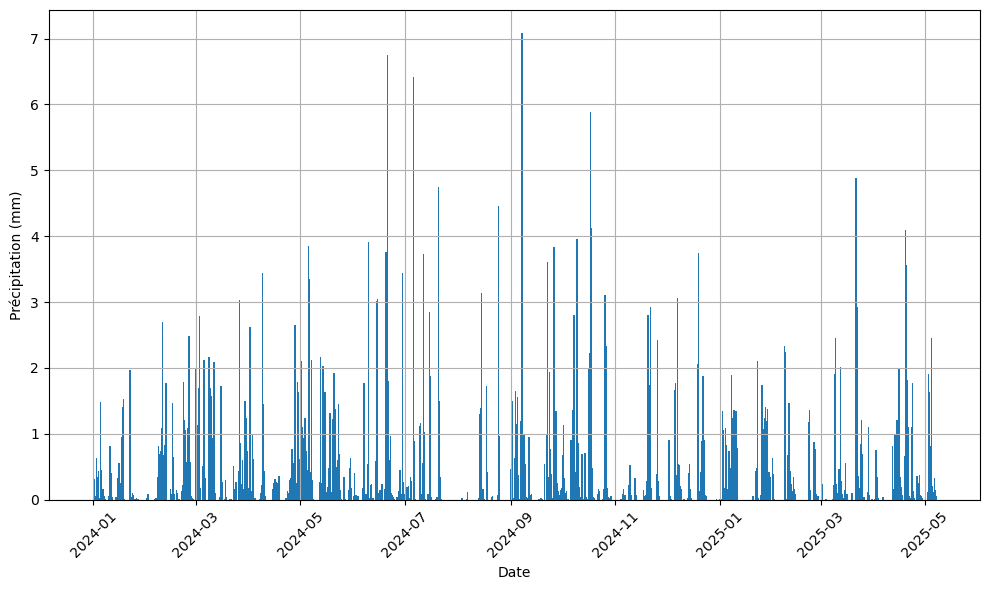

Cumul total: 1802.98 mm


In [61]:
#Calcul des précipitations cumulées pour chaque maille
precipitation_BV = ds['Precipitation_pondérées'].sum(dim=('latitude', 'longitude'))/Facteur_pondération.sum()
dates = ds.valid_time.values

plt.figure(figsize=(10, 6))
plt.bar(dates, precipitation_BV)

plt.xlabel("Date")
plt.ylabel("Précipitation (mm)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcul du cumul total sur la période
cumul = precipitation_BV.sum()
print(f"Cumul total: {cumul:.2f} mm")


#### 6.Export des données dans un tableau .csv

In [64]:
df = pd.DataFrame({
    'Date': ds['valid_time'].values,
    'Pluie (mm)': precipitation_BV.values,})
folder_out = r"C:\Users\stagiaire\Desktop\DATA_ERA"

output_file = 'ERA_2024_CELE_grib_.csv'
output_path = os.path.join(folder_out, output_file)
df.to_csv(output_path, index=False)

print(f"Données journalières exportées avec succès vers '{output_file}'")
df

Données journalières exportées avec succès vers 'ERA_2024_CELE_grib_.csv'


,Date,Pluie (mm)
0,2023-12-31 01:00:00,0.0
1,2023-12-31 02:00:00,0.0
2,2023-12-31 03:00:00,0.0
3,2023-12-31 04:00:00,0.0
4,2023-12-31 05:00:00,0.0
...,...,...
11851,2025-05-07 20:00:00,0.0
11852,2025-05-07 21:00:00,0.0
11853,2025-05-07 22:00:00,0.0
11854,2025-05-07 23:00:00,0.0
